In [1]:
"""Schrödinger equation"""

__author__    = "Evgueni Dinvay"
__credit__    = ["Evgueni Dinvay"]

__date__      = "2023-11-24"

# The Schrödinger equation



Here we demonstrate how the multiwavelets machinery can be exploited for time evolution simulations
of the following one dimensional equation
\begin{equation}
    i \partial_t \Psi
    =
    \left( - \partial_x^2 + V(x) \right) \Psi
    ,
\end{equation}
where we restrict ourselves to consideration of a time independent potential $V$.
This equation is complemented by a given initial wave function $\Psi(x, 0) = \Psi_0(x)$.
As an example, we take a harmonic potential and a gaussian initial wave packet.


A common way of numerical treatment of this equation
is to choose a small time step $t > 0$ and construct the time evolution operator
\begin{equation}
    \Psi(t)
    =
    \exp
    \left(
        i t \partial_x^2 -i t V
    \right)
    \Psi_0
\end{equation}
on interval $[0, t]$.
Then applying it iteratively one can arrive to the solution
at some given finite time moment,
thanks to the semigroup property of the propagator.
As we normally do not have an access to the full collection of eigenfunctions and eigenvalues
for the Hamiltonian, we have to split the propagator on kinetic
$
    \exp
    \left(
        i t \partial_x^2
    \right)
$
and potential 
$
    \exp
    \left(
        -i t V
    \right)
$
parts.
Note that the latter is a multiplication operator in the physical space.


We will make use of the following fourth order scheme
\begin{equation}
    \exp ( At + Bt )
    =
    \exp \left(  \frac t6  B \right)
    \exp \left(  \frac t2  A \right)
    \exp \left(  \frac {2t}3  \widetilde B \right)
    \exp \left(  \frac t2  A \right)
    \exp \left(  \frac t6  B \right)
    +
    \mathcal O \left( t^5 \right)
    ,
\end{equation}
where
\begin{equation}
    \widetilde B
    =
    B
    +
    \frac{t^2}{48}
    [ B, [A, B]]
    .
\end{equation}
In the case of $A = i \partial_x^2$ and $B = -i V$
this
$
    \widetilde B
$
turns out to be a multiplication operator containing potential gradient $\partial_x V(x)$.
Remarkably,
this high order scheme requires only two applications
of the free-particle semigroup operator
$
    \exp \left(  it  \partial_x^2 / 2 \right)
$
per time step.


In [2]:
class ChinChenA(object):
    def __init__(self, expA, expB, exp_tildeB):
        self.expA = expA
        self.expB = expB
        self.exp_tildeB = exp_tildeB
    def __call__(self, u):
        u = self.expB(u)        # 1/6*dt
        u = self.expA(u)        # 1/2*dt
        u = self.exp_tildeB(u)  # 2/3*dt
        u = self.expA(u)        # 1/2*dt
        u = self.expB(u)        # 1/6*dt
        return u    

`expA`: stands for operator $\exp \left(  \frac t2  A \right) = \exp \left(  i \frac t2  \partial_x^2 \right)$


`expB`: stands for operator $\exp \left(  \frac t6  B \right) = \exp \left(  -i \frac t6  V \right)$


`exp_tildeB`: stands for operator
$
    \exp \left(  \frac {2t}3  \widetilde B \right) = \exp \left(  -i \frac {2t}3  \widetilde V \right)
$
with
$
    \widetilde V
    =
    V
    -
    \frac{t^2}{24}
    ( \partial_x V )^2
$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from vampyr import vampyr1d as vp1
from vampyr import LegendreBasis

# Define parameters, final time moment and time step
x0 = 0.3
sigma = 0.04
x1 = 0.5
V0 = 25000
N = 10
t_period = np.pi / np.sqrt(V0)
time_step = 0.5 * t_period / N

# Set the precision and make the MRA
precision = 1.0e-5
finest_scale = 9
mra = vp1.MultiResolutionAnalysis(vp1.BoundingBox(0), LegendreBasis(5))

# Make the scaling projector
P = vp1.ScalingProjector(mra, prec = precision)

In [4]:
class MultiplicationOperator(object):
    def __init__(self, function):
        self.function = function
    def __call__(self, function):
        return self.function * function

\begin{equation*}
    U
    =
    U \left( \widehat H, t \right)
    =
    \exp \left( -i \widehat H t \right)
    =
    \begin{pmatrix}
        \cos \widehat H t
        &
        \sin \widehat H t
        \\
        - \sin \widehat H t
        &
        \cos \widehat H t
    \end{pmatrix}
    =
    \begin{pmatrix}
        \Re U
        &
        -\Im U
        \\
        \Im U
        &
        \Re U
    \end{pmatrix}
\end{equation*}

In [5]:
class UnitaryExponentGroup(object):
    def __init__(self, real, imag):
        self.real = real
        self.imag = imag
    def __call__(self, psi):
        u = psi[0]
        v = psi[1]
        res0 = self.real(u) - self.imag(v)
        res1 = self.imag(u) + self.real(v)
        return np.array([ res0, res1 ])     

The unitary potential semigroup operator
\begin{equation*}
    U
    =
    U \left( V, t \right)
    =
    \exp \left( -i V t \right)
    \approx
    \begin{pmatrix}
        P \cos (V t)
        &
        P \sin (V t)
        \\
        - P \sin (V t)
        &
        P \cos (V t)
    \end{pmatrix}
    =
    \begin{pmatrix}
        P \Re \exp \left( -i V t \right)
        &
        - P \Im \exp \left( -i V t \right)
        \\
        P \Im \exp \left( -i V t \right)
        &
        P \Re \exp \left( -i V t \right)
    \end{pmatrix}
\end{equation*}
which should be understood as a multiplication operator.

In [6]:
def create_unitary_potential_operator(P, V, t):
    def real(x):
        return np.cos(V(x) * t)
    real = P(real)
    def imag(x):
        return - np.sin(V(x) * t)
    imag = P(imag)
    real = MultiplicationOperator(real)
    imag = MultiplicationOperator(imag)
    return UnitaryExponentGroup(real, imag)

The Schrodinger free-particle semigroup operator
\begin{equation*}
    U
    =
    U \left( \widehat T, t \right)
    =
    U \left( - \partial_x^2, t \right)
    =
    \exp \left( it \partial_x^2 \right)
    =
    \begin{pmatrix}
        \Re \exp \left( it \partial_x^2 \right)
        &
        - \Im \exp \left( it \partial_x^2 \right)
        \\
        \Im \exp \left( it \partial_x^2 \right)
        &
        \Re \exp \left( it \partial_x^2 \right)
    \end{pmatrix}
\end{equation*}

In [7]:
def create_unitary_kinetic_operator(mra, precision, time, finest_scale):
    real = vp1.TimeEvolutionOperator(mra, precision, time, finest_scale, False)
    imag = vp1.TimeEvolutionOperator(mra, precision, time, finest_scale, True)
    return UnitaryExponentGroup(real, imag)

It is well known that in the harmonic potential
$
    V(x) = V_0 (x - x_1)^2
$
the density
$
    \left| \Psi(t) \right|^2
$
oscillates with the period
$
    t_{\text{period}} = \pi / \sqrt{V_0}
    .
$
More precisely,
$
    \Psi \left( t_{\text{period}} \right) = - \Psi_0
    .
$
This can immediately be seen taking into account that
the eigenvalues for the Hamiltonian are
$
    \sqrt{V_0} ( 2n + 1)
    .
$

For the time step $t$ the scheme modification potential
$
    \widetilde V
    =
    V
    -
    \frac{t^2}{24}
    ( \partial_x V )^2
    =
    \widetilde V_0 (x - x_0)^2
$
where
$
    \widetilde V_0
    =
    V_0
    -
    \frac{(tV_0)^2}6
    .
$

In [8]:
# Define the harmonic potential with its scheme modification
def V(x):
    return V0 * (x[0] - x1)**2
def tilde_V(x):
    A = V0 - ( time_step * V0 )**2 / 6.0
    return A * (x[0] - x1)**2

# Define the iteration procedure
iteratorA = ChinChenA(
    expA = create_unitary_kinetic_operator(mra, precision, time_step / 2, finest_scale),
    expB = create_unitary_potential_operator(P, V, time_step / 6),
    exp_tildeB = create_unitary_potential_operator(P, tilde_V, 2 * time_step / 3)
)

Let an initial condition be of the form
\begin{equation*}
    \Psi_0(x)
    =
    \left(
        \frac 1{2 \pi \sigma^2}
    \right)^{1/4}
    \exp
    \left(
        - \frac {(x - x_0)^2}{4 \sigma^2}
    \right)
\end{equation*}
with $x_0 = 0.3$ and $\sigma = 0.04$.
All the parameters are chosen in a way that the solution
stays localized mainly on the space interval $[0, 1]$.

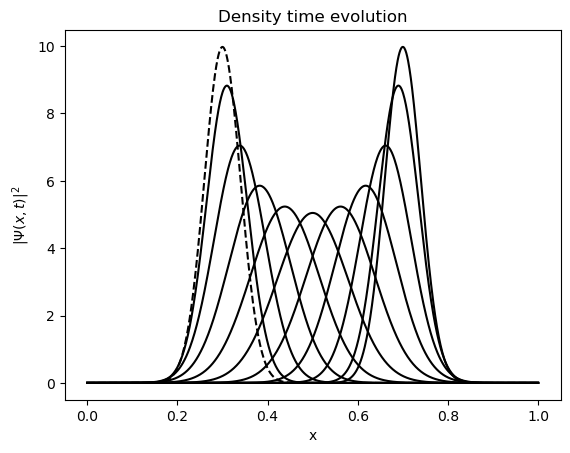

In [9]:
# Define the initial wave function
psi0 = vp1.GaussFunc(
    beta = 1.0 / (4 * sigma**2),alpha = (2 * np.pi * sigma**2)**(-1/4), position = [x0]
)
psi0 = np.array([ P(psi0), vp1.FunctionTree(mra).setZero() ])

# Plot the initial density
x_vec = np.linspace(0, 0.9999, 1000)
real_psi0_plt = np.array([( psi0[0] * psi0[0] + psi0[1] * psi0[1] )([x]) for x in x_vec ])
plt.plot(x_vec, real_psi0_plt, '--', color='black')

# Solve the initial value problem and plot the result
psiA = psi0
for n in range(N):
    psiA = iteratorA(psiA)
    densityA = psiA[0] * psiA[0] + psiA[1] * psiA[1]
    densityA_plt = np.array([densityA([x]) for x in x_vec ])
    plt.plot(x_vec, densityA_plt , "black")
    
plt.xlabel('x')
plt.ylabel(r'$| \Psi(x, t) |^2$')
plt.title(r'Density time evolution')
plt.show()

L2-norm of real part error:      0.00011595685155302059
L2-norm of imaginary part error: 9.475768012015029e-05


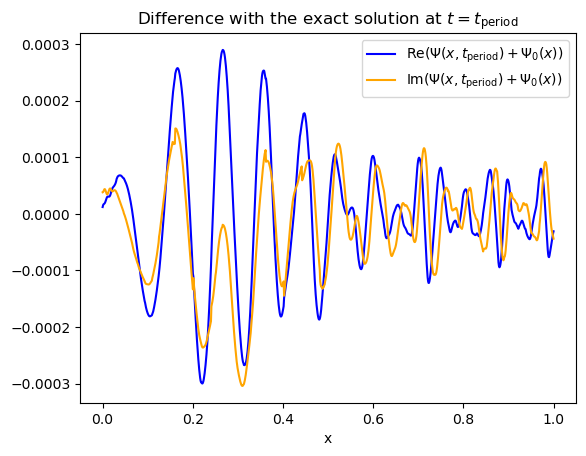

In [10]:
# Continue solving until t = period 
for n in range(N):
    psiA = iteratorA(psiA)

# Find error at t = period
per_errorA = psiA + psi0

print( f"L2-norm of real part error:      {per_errorA[0].norm()}" )
print( f"L2-norm of imaginary part error: {per_errorA[1].norm()}" )

real_psi_plt = np.array([per_errorA[0]([x]) for x in x_vec ])
plt.plot(x_vec, real_psi_plt , "blue", label=r'Re$( \Psi(x, t_{ \text{period} }) + \Psi_0(x) )$')

imag_psi_plt = np.array([per_errorA[1]([x]) for x in x_vec ])
plt.plot(x_vec, imag_psi_plt , "orange", label=r'Im$( \Psi(x, t_{ \text{period} }) + \Psi_0(x) )$')

plt.xlabel('x')
plt.title(r'Difference with the exact solution at $t = t_{ \text{period} }$')
plt.legend()
plt.show()